## 8.12(a) Earth's orbit using Verlet

Position r(x,y) of Earth in its orbital plane: $$\frac{d^2 \mathbf r}{d t^2} = \frac{-G M \mathbf r}{r^3} $$
where M = 1.9891e30 (mass of Sun in kg)

Note, when Earth is at its closest point to the Sun (perihilion):
* its direction of motion is perpendicular to the line between itself and the Sun
* r = 1.471e11 m
* linear velocity v = 3.0287e4 m/s

Write a program to calculate the orbit using Verlet method, with timestep h = 1 hour.

In [1]:
from scipy.constants import G, au
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
def f(r_):
    """ Right-hand-side for velocity equation: gravitational force
    INPUT: r_ = [x, y, vx, vy]
    OUTPUT: Fx, Fy: along-x and -y gravitational forces
    """
    x, y, vx, vy = r_[0], r_[1], r_[2], r_[3]
    from scipy.constants import G  # computationally inefficient but short
    M = 1.9891e30  # [kg] Mass of the Sun
    r = (x**2 + y**2)**.5  # [m] distance to Sun
    prefac = -M*G/r**3
    return np.array([vx, vy, x*prefac, y*prefac], float)

In [3]:
M = 1.9891e30  # [kg] Mass of the Sun
PH = 1.4710e11  # [m] perihelion of the Earth
VP = 3.0287e4  # [m/s] velocity of Earth at perihelion
h = 3600.  # [s] time step

Nrevs = 5  # number of revolutions around the Sun
year = 365.25*24*3600.  # [s] duration of a year
T = Nrevs*year  # [s] duration of integration
Nsteps = int(T/h)  # number of time steps

In [4]:
# initialization of positions and  velocities
pos = np.empty((2, Nsteps), float)  # 1st index: x, y
vel = np.empty((2, Nsteps), float)  # idem for v

# Jump-start with RK2 --------------------------------------------------------|
# I define the x, y axes as: Earth start at perielion, along x>0, with along-y
# positive velocity
v0 = np.array([0., VP])  # initial velocity components
pos[:, 0] = np.array([PH, 0.])
r = (pos[0, 0]**2 + pos[1, 0]**2)**.5
vel[:, 0] = v0 - h*G*M*pos[:, 0]/r**3


# Verlet iterations ----------------------------------------------------------|
for tt in range(1, Nsteps):
    pos[:, tt] = pos[:, tt-1] + h*vel[:, tt-1]  # updating positions
    r = (pos[0, tt]**2 + pos[1, tt]**2)**.5  # distance from Sun squared
    vel[:, tt] = vel[:, tt-1] - h*G*M*pos[:, tt]/r**3  # updating velocities

Make a plot of the orbit, showing several complete revolutions. Should be very slightly, but visibly, non-circular.

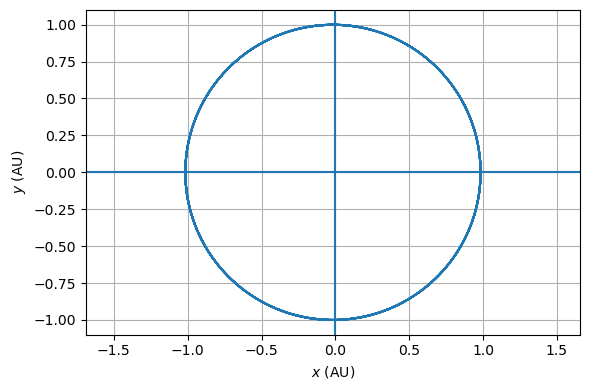

In [5]:
pos_AU = pos/au  # for clearer axes
plt.figure(dpi=100)
plt.plot(pos_AU[0, :], pos_AU[1, :])
plt.axvline(0.)
plt.axhline(0.)
plt.grid()
plt.xlabel('$x$ (AU)')
plt.ylabel('$y$ (AU)')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 8.13 (a) Earth's orbit using Bulirsch-Stoer

Calculate Earth's orbit using MMP + Richardson extrapolation, more accurately the previous program with Verlet.
* Positional accuracy 1 km per year
* Divide the orbit into intervals of length H = 1 week

In [12]:
Nrevs = 1.  #reset from previous part
H = year/52  # [s] one week
Nbig = int(year/H) + 1  # number of "big steps": enough for at least a year
T = H*Nbig  # [s] total duration of integration
delta = 1e3/year  # [m/s] Required position accuracy

In [13]:
# initialization of positions and velocities and time-points
tpoints = np.arange(0., T, H)
x, y = [], []  # keep lists of x and y separately
r = np.array([PH, 0., 0., VP], float)  # initial x, y, vx, vy respectively

# Do the "big steps" of size H -----------------------------------------------|
# virtually all lines are from Newman's bulirsch.py file
for t in enumerate(tpoints):

    x.append(r[0]/au)  # in astronomical units for easier plotting
    y.append(r[1]/au)

    # Do one modified midpoint step to get things started
    n = 1
    r1 = r + 0.5*H*f(r)  # recall that this is 4D
    r2 = r + H*f(r1)  # recall that this is 4D

    # The array R1 stores the first row of the extrapolation table,
    # which contains only the single MMP estimate of the solution at the end of the interval
    R1 = np.empty([1, 4], float)
    R1[0] = 0.5*(r1 + r2 + 0.5*H*f(r2))

    # Now increase n until the required accuracy is reached
    error = 2*H*delta
    while error > H*delta:

        n += 1
        h = H/n

        # Modified midpoint method
        r1 = r + 0.5*h*f(r)
        r2 = r + h*f(r1)
        for i in range(n-1):
            r1 += h*f(r2)
            r2 += h*f(r1)

        # Calculate extrapolation estimates.
        # Arrays R1 and R2 hold the two most recent lines of the table
        R2 = R1
        R1 = np.empty([n, 4], float)
        R1[0] = 0.5*(r1 + r2 + 0.5*h*f(r2))
        for m in range(1, n):
            epsilon = (R1[m-1]-R2[m-1])/((n/(n-1))**(2*m)-1)
            R1[m] = R1[m-1] + epsilon
        error = abs(epsilon[0])

    #print("We computed {} lines in the extrapolation table".format(n))

    # Set r equal to the most accurate estimate we have, before moving on to the next big step
    r = R1[n-1]

Make a plot of the orbit, showing at least one complete revolution around the Sun.

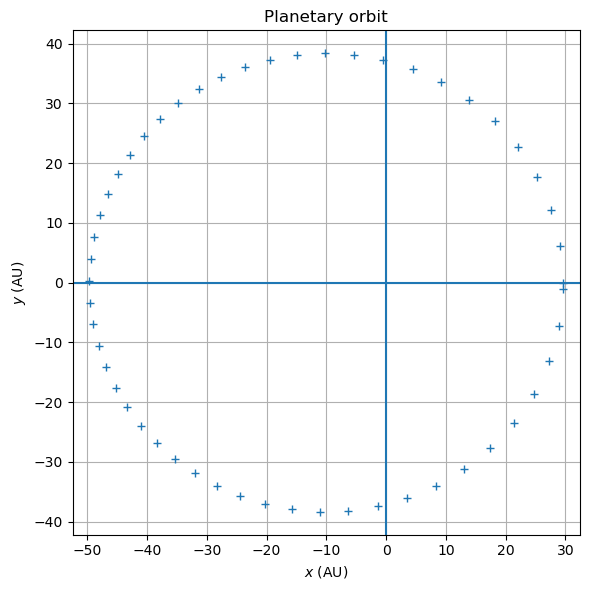

In [14]:
plt.figure(figsize=(6, 6), dpi=100)
plt.plot(x, y, '+')   # one cross every week
plt.axvline(0.)
plt.axhline(0.)
plt.grid()
plt.xlabel('$x$ (AU)')
plt.ylabel('$y$ (AU)')
plt.axis('equal')
plt.title("Planetary orbit")
plt.tight_layout()
plt.show()

Now try it for Pluto's orbit, which is significantly more elliptical than Earth's. At perihilion: r = 4.4368e12 m, v = 6.1218 /s 

In [11]:
PH = 4.4368e12  # [m] perihelion
VP = 6.1218e3  # [m/s] velocity at perihelion
year = 249*365.25*24*3600.  # [s] duration of a PLuto year